In [91]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from scipy.stats import mode
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

In [92]:
'''
1. Retrieve and load the Olivetti faces dataset
'''
faces = fetch_olivetti_faces()

In [93]:
X = faces.data
y = faces.target
X.shape, y.shape

((400, 4096), (400,))

In [94]:
min_value = np.min(X)
max_value = np.max(X)
print(min_value, max_value)

0.0 1.0


In [95]:
face_index = np.unique(y, return_index=True)[1]
face_index

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
       260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380,
       390], dtype=int64)

In [96]:
unique_faces = X[face_index]

In [97]:
'''
2. Split the training set, a validation set,
    and a test set using stratified sampling to ensure that
    there are the same number of images per person in each set.
    Provide your rationale for the split ratio.
'''
train_indices = []
val_indices = []
test_indices = []

for index in face_index:
  person_indices = np.arange(index, index + 10)

  np.random.shuffle(person_indices)

  train_indices.extend(person_indices[:6])
  val_indices.extend(person_indices[6:8])
  test_indices.extend(person_indices[8:])

train_indices = np.array(train_indices)
val_indices = np.array(val_indices)
test_indices = np.array(test_indices)

X_train, y_train = X[train_indices], y[train_indices]
X_val, y_val = X[val_indices], y[val_indices]
X_test, y_test = X[test_indices], y[test_indices]

In [98]:
'''
3. Using k-fold cross validation,
    train a classifier to predict which person is represented in each picture,
    and evaluate it on the validation set.
'''
classifier = RandomForestClassifier(n_estimators=100, random_state=21)
kfold = KFold(n_splits=3, shuffle=True, random_state=21)

cross_val_scores = cross_val_score(classifier, X_train, y_train, cv=kfold)
print(cross_val_scores)
print(np.mean(cross_val_scores))

[0.7625 0.775  0.7375]
0.7583333333333334


In [99]:
classifier.fit(X_train, y_train)
validation_accuracy = classifier.score(X_val, y_val)
print(validation_accuracy)

0.95


In [100]:
'''
4. Using Agglomerative Hierarchical Clustering (AHC) and centroid-based clustering rule,
    reduce the dimensionality of the set by using the following similarity measures:
    a) Euclidean Distance
    b) Minkowski Distance (set p=1)
    c) Cosine Similarity
    For each distance measure, perform the following steps:
        Apply AHC to cluster the dataset.
        Plot the corresponding dendrograms for each similarity measure.
        Discuss the differences observed in the clustering behavior based on the different similarity measures.
'''
def plot_dendrogram(linkage_matrix, title):
    plt.figure(figsize=(10, 7))
    dendrogram(linkage_matrix)
    plt.title(title)
    plt.xlabel('Sample index')
    plt.ylabel('Distance')
    plt.show()

scipy.cluster.hierarchy.linkage(y, method='single', metric='euclidean')

y : ndarray
A condensed or redundant distance matrix. A condensed distance matrix is a flat array containing the upper triangular of the distance matrix. This is the form that pdist returns. Alternatively, a collection of m observation vectors in n dimensions may be passed as an m by n array.

https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.linkage.html

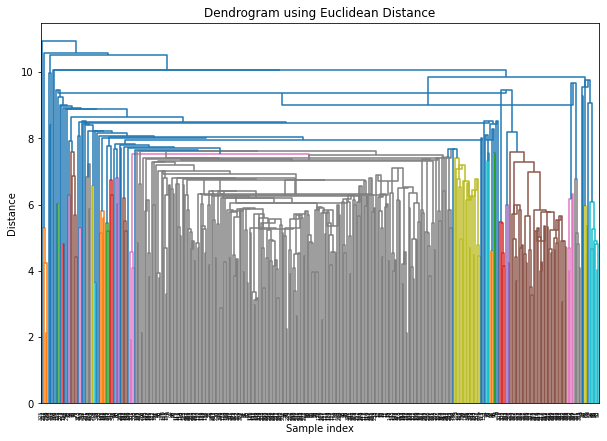

In [101]:
# Euclidean
euclidean_distance = pdist(X, metric="euclidean")
euclidean_linkage = linkage(euclidean_distance, method='centroid')
plot_dendrogram(euclidean_linkage, "Dendrogram using Euclidean Distance")

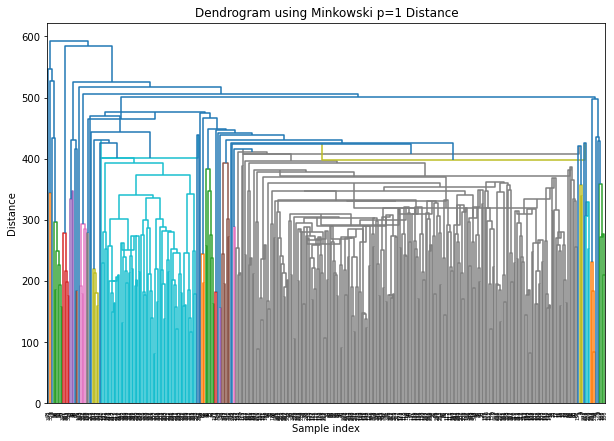

In [102]:
# Minkowski (p=1), (Manhattan)
minkowski_distance = pdist(X, metric="minkowski", p=1)
minkowski_linkage = linkage(minkowski_distance, method='centroid')
plot_dendrogram(minkowski_linkage, "Dendrogram using Minkowski p=1 Distance")

Y = pdist(X, 'cosine')

Computes the cosine distance between vectors u and v,

https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html

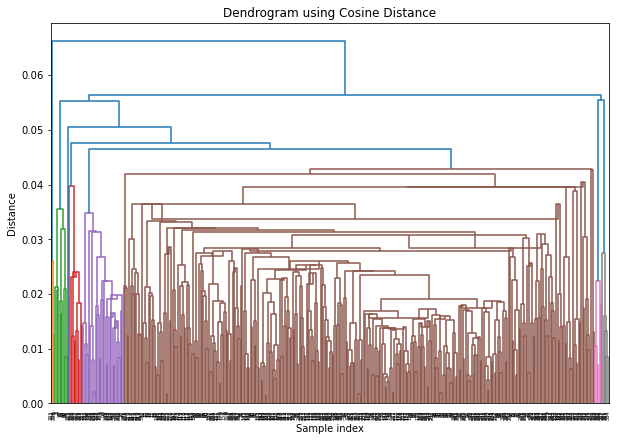

In [103]:
# Cosine Similarity
cosine_distance_matrix = pdist(X, metric='cosine')
cosine_linkage = linkage(cosine_distance_matrix, method='centroid')
plot_dendrogram(cosine_linkage, "Dendrogram using Cosine Distance")

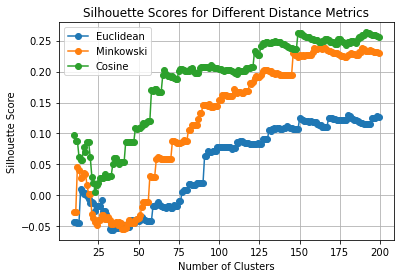

In [104]:
cluster_range = range(10, 200)
silhouette_scores_dict = {'Euclidean': [], 'Minkowski': [], 'Cosine': []}


linkage_matrices = {
    'Euclidean': euclidean_linkage,
    'Minkowski': minkowski_linkage,
    'Cosine': cosine_linkage
}

for num_clusters in cluster_range:
    for metric_name, linkage_matrix in linkage_matrices.items():
        cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

        if metric_name == 'Euclidean':
            sil_score = silhouette_score(X, cluster_labels, metric='euclidean')
        elif metric_name == 'Minkowski':
            sil_score = silhouette_score(X, cluster_labels, metric='minkowski', p=1)
        elif metric_name == 'Cosine':
            sil_score = silhouette_score(X, cluster_labels, metric='cosine')
        
        silhouette_scores_dict[metric_name].append(sil_score)

for metric_name in silhouette_scores_dict:
    plt.plot(cluster_range, silhouette_scores_dict[metric_name], marker='o', label=metric_name)

plt.title('Silhouette Scores for Different Distance Metrics')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True)
plt.show()

In [105]:
for metric_name, scores in silhouette_scores_dict.items():
    max_score = max(scores)
    optimal_clusters = cluster_range[scores.index(max_score)]  
    print(f"Maximum Silhouette Score for {metric_name}: {max_score:.4f} at {optimal_clusters} clusters")

Maximum Silhouette Score for Euclidean: 0.1290 at 180 clusters
Maximum Silhouette Score for Minkowski: 0.2387 at 165 clusters
Maximum Silhouette Score for Cosine: 0.2635 at 191 clusters


In [106]:
'''
6. Use the set from (4(a), 4(b), or 4(c)) to train a classifier as in (3) using k-fold cross validation.
'''
euclidean_distance_squareform = squareform(pdist(X, metric="euclidean"))
minkowski_distance_squareform = squareform(pdist(X, metric="minkowski", p=1))
cosine_distance_squareform = squareform(pdist(X, metric='cosine'))

In [107]:
train_indices = []
val_indices = []
test_indices = []

for index in face_index:
  person_indices = np.arange(index, index + 10)

  np.random.shuffle(person_indices)

  train_indices.extend(person_indices[:6])
  val_indices.extend(person_indices[6:8])
  test_indices.extend(person_indices[8:])

train_indices = np.array(train_indices)
val_indices = np.array(val_indices)
test_indices = np.array(test_indices)

X_train_euclidean, y_train = euclidean_distance_squareform[train_indices], y[train_indices]
X_val_euclidean, y_val = euclidean_distance_squareform[val_indices], y[val_indices]
X_test_euclidean, y_test = euclidean_distance_squareform[test_indices], y[test_indices]

In [108]:
classifier = RandomForestClassifier(n_estimators=100, random_state=21)
kfold = KFold(n_splits=3, shuffle=True, random_state=21)

In [109]:
cv_scores_euclidean = cross_val_score(classifier, X_train_euclidean, y_train, cv=kfold)
print(f"Euclidean Cross-Validation Scores: {cv_scores_euclidean}")
print(f"Euclidean Mean Score: {np.mean(cv_scores_euclidean)}")

Euclidean Cross-Validation Scores: [0.675  0.6875 0.6375]
Euclidean Mean Score: 0.6666666666666666


In [110]:
classifier.fit(X_train_euclidean, y_train)
validation_accuracy = classifier.score(X_val_euclidean, y_val)
print(validation_accuracy)

0.8375


In [111]:
train_indices = []
val_indices = []
test_indices = []

for index in face_index:
  person_indices = np.arange(index, index + 10)

  np.random.shuffle(person_indices)

  train_indices.extend(person_indices[:6])
  val_indices.extend(person_indices[6:8])
  test_indices.extend(person_indices[8:])

train_indices = np.array(train_indices)
val_indices = np.array(val_indices)
test_indices = np.array(test_indices)

X_train_minkowski, y_train = minkowski_distance_squareform[train_indices], y[train_indices]
X_val_minkowski, y_val = minkowski_distance_squareform[val_indices], y[val_indices]
X_test_minkowski, y_test = minkowski_distance_squareform[test_indices], y[test_indices]

In [112]:
cv_scores_minkowski = cross_val_score(classifier, X_train_minkowski, y_train, cv=kfold)
print(f"Minkowski Cross-Validation Scores: {cv_scores_minkowski}")
print(f"Minkowski Mean Score: {np.mean(cv_scores_minkowski)}")

Minkowski Cross-Validation Scores: [0.625  0.6625 0.7   ]
Minkowski Mean Score: 0.6625


In [113]:
classifier.fit(X_train_minkowski, y_train)
validation_accuracy = classifier.score(X_val_minkowski, y_val)
print(validation_accuracy)

0.8


In [114]:
train_indices = []
val_indices = []
test_indices = []

for index in face_index:
  person_indices = np.arange(index, index + 10)

  np.random.shuffle(person_indices)

  train_indices.extend(person_indices[:6])
  val_indices.extend(person_indices[6:8])
  test_indices.extend(person_indices[8:])

train_indices = np.array(train_indices)
val_indices = np.array(val_indices)
test_indices = np.array(test_indices)

X_train_cosine, y_train = cosine_distance_squareform[train_indices], y[train_indices]
X_val_cosine, y_val = cosine_distance_squareform[val_indices], y[val_indices]
X_test_cosine, y_test = cosine_distance_squareform[test_indices], y[test_indices]

In [115]:
cv_scores_cosine = cross_val_score(classifier, X_train_cosine, y_train, cv=kfold)
print(f"Cosine Cross-Validation Scores: {cv_scores_cosine}")
print(f"Cosine Mean Score: {np.mean(cv_scores_cosine)}")

Cosine Cross-Validation Scores: [0.75   0.6625 0.7   ]
Cosine Mean Score: 0.7041666666666666


In [116]:
classifier.fit(X_train_cosine, y_train)
validation_accuracy = classifier.score(X_val_cosine, y_val)
print(validation_accuracy)

0.8
